# ANOVA dumb group name - housing price prediction

In [171]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns

In [172]:
# Read in the train and test data
train_data = pd.read_csv("train.csv", index_col = 0, encoding = "utf-8")
sale_price = train_data[['SalePrice']]
test_data = pd.read_csv("test.csv", index_col = 0, encoding = "utf-8")
test_data['SalePrice'] = 0

In [173]:
# Combine the train and test data for the moment, so manipulations are applied to both
all_data = pd.concat([train_data, test_data], axis = 0).reset_index(drop = True)

###### Target is highly skewed! Use a transformation to correct

True


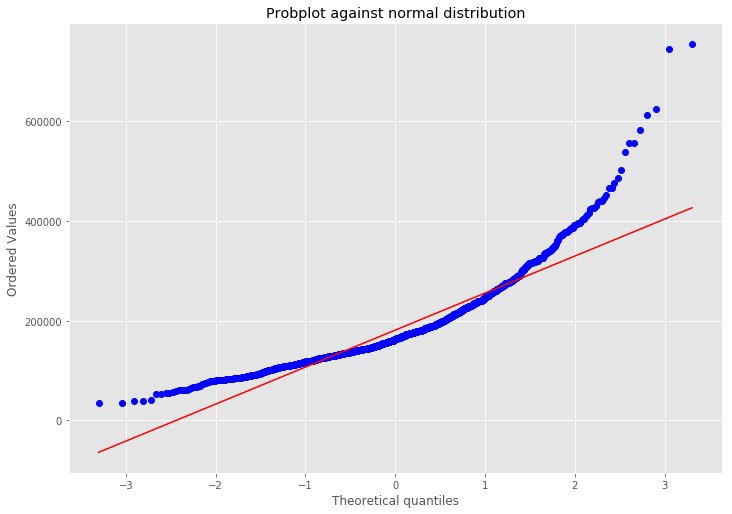

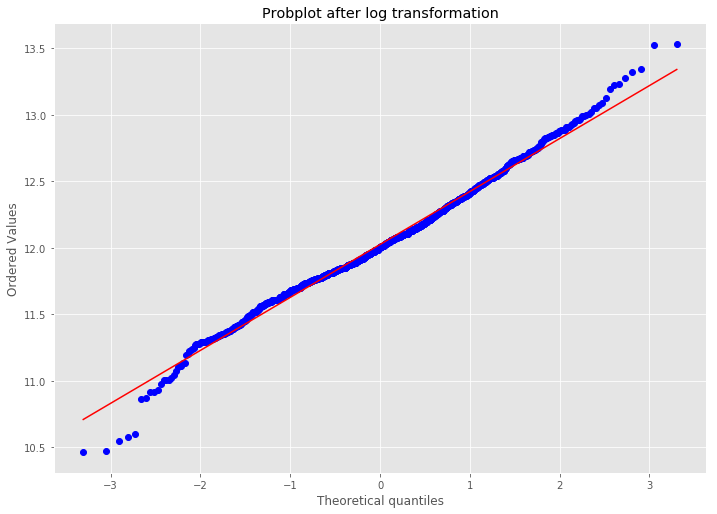

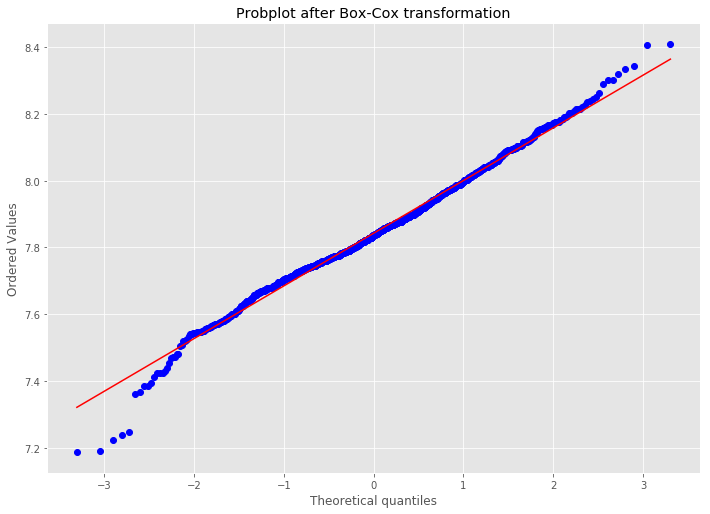

In [174]:
# Compare normality of target under no transformation, optimum box-cox and log
fig1, ax1 = plt.subplots(figsize=(11.7, 8.27))
prob1 = stats.probplot(sale_price['SalePrice'], dist=stats.norm, plot=ax1)
ax1.set_title('Probplot against normal distribution')

print(all(sale_price['SalePrice'] > 0))
fig2, ax2 = plt.subplots(figsize=(11.7, 8.27))
sale_price_log = stats.boxcox(sale_price, lmbda = 0)
prob2 = stats.probplot(sale_price_log.flatten(), dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after log transformation')

fig3, ax3 = plt.subplots(figsize=(11.7, 8.27))
sale_price_bc, lmbda = stats.boxcox(sale_price)
prob3 = stats.probplot(sale_price_bc.flatten(), dist=stats.norm, plot=ax3)
ax3.set_title('Probplot after Box-Cox transformation')

plt.show()
# Optimal Lambda is -0.07692396

(array([0.02796873, 0.05593746, 0.15662488, 0.72159319, 2.38293564,
        2.48362306, 1.51031132, 0.62090577, 0.16221862, 0.04474997]),
 array([7.18570046, 7.30814641, 7.43059237, 7.55303832, 7.67548427,
        7.79793022, 7.92037617, 8.04282212, 8.16526808, 8.28771403,
        8.41015998]),
 <a list of 10 Patch objects>)

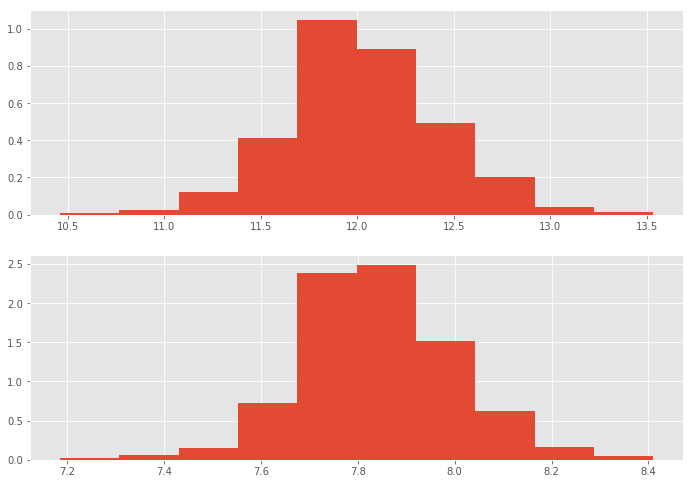

In [175]:
# Plot histograms of the lob and box-cos transformed target data
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(11.7, 8.27))
ax0, ax1, = axes.flatten()
ax0.hist(sale_price_log, density = True)
ax1.hist(sale_price_bc, density = True)

###### The target data transformed by the logarithm (lambda = 0) looks pretty good and is more easily interpreted - continue with this

### Investigating missingness

In [176]:
# Get an overview of the feature set
all_data.describe()
# 37 numerical variables inc. SalePrice

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2917.000000,2917.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2760.000000,2918.000000,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429894,0.061364,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1978.113406,1.766621,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,90491.588215
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,439.543659,440.766258,392.362079,428.701456,46.396825,506.051045,0.524736,0.245687,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,25.574285,0.761624,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,106496.379333
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,0.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1960.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,0.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,467.000000,989.500000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1979.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,34900.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,805.500000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,163000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [177]:
all_data.columns[all_data.isnull().any()]
# 25 features with missing data

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

In [178]:
# View the columns with missing data
all_data.loc[:, ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType']]

,MSZoning,LotFrontage,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Electrical,BsmtFullBath,BsmtHalfBath,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
0,RL,65.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,SBrkr,1.0,0.0,Gd,Typ,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,NaN,NaN,NaN,WD
1,RL,80.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,SBrkr,0.0,1.0,TA,Typ,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,NaN,NaN,NaN,WD
2,RL,68.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,SBrkr,1.0,0.0,Gd,Typ,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,NaN,NaN,NaN,WD
3,RL,60.0,NaN,AllPub,Wd Sdng,Wd Shng,None,0.0,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,SBrkr,1.0,0.0,Gd,Typ,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,NaN,NaN,NaN,WD
4,RL,84.0,NaN,AllPub,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,SBrkr,1.0,0.0,Gd,Typ,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,NaN,NaN,NaN,WD
5,RL,85.0,NaN,AllPub,VinylSd,VinylSd,None,0.0,Gd,TA,No,GLQ,732.0,Unf,0.0,64.0,796.0,SBrkr,1.0,0.0,TA,Typ,NaN,Attchd,1993.0,Unf,2.0,480.0,TA,TA,NaN,MnPrv,Shed,WD
6,RL,75.0,NaN,AllPub,VinylSd,VinylSd,Stone,186.0,Ex,TA,Av,GLQ,1369.0,Unf,0.0,317.0,1686.0,SBrkr,1.0,0.0,Gd,Typ,Gd,Attchd,2004.0,RFn,2.0,636.0,TA,TA,NaN,NaN,NaN,WD
7,RL,NaN,NaN,AllPub,HdBoard,HdBoard,Stone,240.0,Gd,TA,Mn,ALQ,859.0,BLQ,32.0,216.0,1107.0,SBrkr,1.0,0.0,TA,Typ,TA,Attchd,1973.0,RFn,2.0,484.0,TA,TA,NaN,NaN,Shed,WD
8,RM,51.0,NaN,AllPub,BrkFace,Wd Shng,None,0.0,TA,TA,No,Unf,0.0,Unf,0.0,952.0,952.0,FuseF,0.0,0.0,TA,Min1,TA,Detchd,1931.0,Unf,2.0,468.0,Fa,TA,NaN,NaN,NaN,WD
9,RL,50.0,NaN,AllPub,MetalSd,MetalSd,None,0.0,TA,TA,No,GLQ,851.0,Unf,0.0,140.0,991.0,SBrkr,1.0,0.0,TA,Typ,TA,Attchd,1939.0,RFn,1.0,205.0,Gd,TA,NaN,NaN,NaN,WD


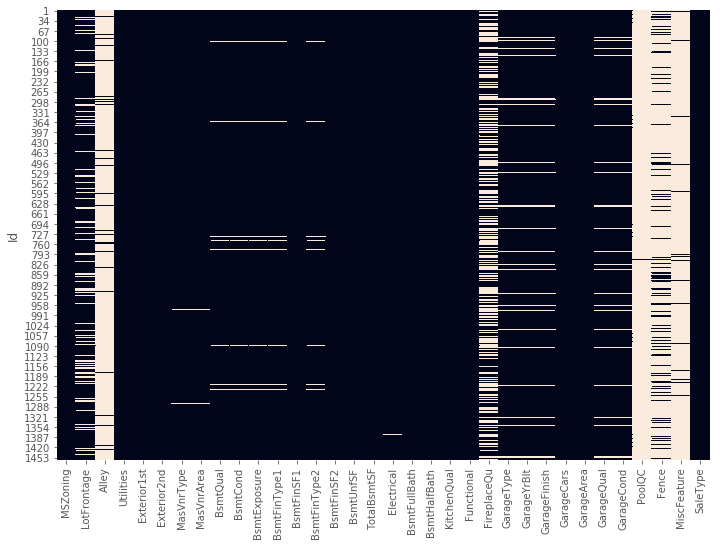

In [179]:
# Visualize missing data combinations
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.heatmap(train_data.loc[:, ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType']].isnull(), cbar = False, ax=ax)

### Data cleaning and preliminary feature selection
Most appropriate method of imputation has been selected for each feature based on missingness quantity, pattern, feature characteristics and feature importance

In [180]:
# Replace the missing values from the basement data with random selections from the appropriate options
np.random.seed(0)
basement = all_data.loc[:,['BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',]]
basement[(basement.isnull().any(axis = 1)) & (basement.loc[:,'TotalBsmtSF'] != 0)] =\
basement[(basement.isnull().any(axis = 1)) & (basement.loc[:,'TotalBsmtSF'] != 0)].apply(lambda x: x.fillna(np.random.choice(x.dropna())), axis=0)

# Replace the NA's that correspond to no garage with "None"
basement.loc[basement.isnull().any(axis = 1),['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = "None"
all_data.loc[:,['BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',]] = basement

# Remove the singular missing completely at random observation in the electrical column
all_data = all_data.drop(all_data[all_data.loc[:,'Electrical'].isnull()].index[0], axis = 0)

# Replace all NA values that actually mean no fireplaces with 'None'
all_data.loc[(all_data['FireplaceQu'].isnull()) & (all_data['Fireplaces'] == 0),'FireplaceQu'] = "None"

# Replace all NA values that actually mean no garage with 'None'
all_data.loc[(all_data['GarageType'].isnull()) &(all_data['GarageArea'] == 0),'GarageType'] = 'None'
all_data.loc[(all_data['GarageFinish'].isnull()) &(all_data['GarageArea'] == 0),'GarageFinish'] = 'None'
all_data.loc[(all_data['GarageQual'].isnull()) &(all_data['GarageArea'] == 0),'GarageQual'] = 'None'

# Impute for the very few missing values in the GarageQual and GarageFinish
GarFin_index = (all_data[(all_data.GarageArea!=0) & (all_data.GarageFinish.isnull())]['GarageFinish']).index
GarQual_index  = (all_data[(all_data.GarageArea!=0) & (all_data.GarageQual.isnull())]['GarageQual']).index
all_data.loc[GarQual_index,'GarageQual'] = np.random.choice(['TA', 'Fa', 'Gd','Ex', 'Po'])
all_data.loc[GarFin_index,'GarageFinish'] = np.random.choice(['Fin','RFn','Unf'])

# Impute using the mean/median for the very few missing values in the other garage columns
all_data.loc[(all_data['GarageYrBlt'].isnull()) &(all_data['GarageArea'] == 0),'GarageYrBlt'] = 'None'
all_data.loc[2576,'GarageArea'] = all_data.GarageArea.mean()
all_data.loc[2576,'GarageCars'] = all_data.GarageCars.mean()
all_data.loc[[2126,2576],'GarageYrBlt'] = all_data.GarageYrBlt[all_data.GarageYrBlt != 'None'].median()

# Replace all NA values that actualy mean no pool with "None"
all_data.loc[(all_data['PoolQC'].isnull()) & (all_data['PoolArea'] == 0),'PoolQC'] = 'None'

# Impute for the very few missing values in the PoolQC column
poolna_index = (all_data[(all_data.PoolArea!=0) & (all_data.PoolQC.isnull())]['PoolQC']).index
all_data.loc[poolna_index[0],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index[1],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index[2],'PoolQC'] = np.random.choice(['Ex','Gd','Fa'])
all_data.loc[poolna_index,'PoolQC']

# Replace all NA values that actualy mean no fence with "None"
all_data['Fence'].fillna(value='None', inplace=True)

# Replace the only NA value with the majority value Typ
all_data['Functional'].fillna(value='Typ', inplace=True)

# Replace the remaining couple of NA values in the BsmtBath columns with values that preserve the column means
all_data.loc[2120, 'BsmtFullBath'] = 1
all_data.loc[2188, 'BsmtFullBath'] = 0
all_data['BsmtHalfBath'].fillna(value=0, inplace=True)

# Replace all NA values that actualy mean no fence with "None"
all_data.loc[(all_data.MiscFeature.isnull()) & (all_data.MiscVal == 0),'MiscFeature'] = 'None'

# Replace the missing value in MicsFeature according to its corresponding MiscValue
all_data.loc[all_data.MiscFeature.isnull(), 'MiscFeature'] = 'Gar2'

# Replace missing values in the Exterior columns with majority values
all_data.loc[all_data.Exterior1st.isnull(),'Exterior1st'] = 'VinylSd'
all_data.loc[all_data.Exterior2nd.isnull(),'Exterior2nd'] = 'VinylSd'
all_data.loc[all_data.MSZoning.isnull(),'MSZoning'] = 'RL'
all_data.loc[all_data.SaleType.isnull(),'SaleType'] = 'WD'
all_data.loc[all_data.KitchenQual.isna(), 'KitchenQual'] = 'Ta'

In [181]:
# For those columns with a larger number of truly missing values, randomly impute
all_lf_index = (all_data[all_data.LotFrontage.isnull()]).index
for idx in all_lf_index:
    all_data.loc[idx,'LotFrontage'] = np.random.choice(all_data.LotFrontage.dropna(), replace = False)

all_mvt_index = (all_data[all_data.MasVnrType.isnull()]).index
for idx in all_mvt_index:
    all_data.loc[idx,'MasVnrType'] = np.random.choice(['None', 'BrkFace', 'Stone'], replace = True)

all_mva_index = (all_data[all_data.MasVnrArea.isnull()]).index
for idx in all_mva_index:
    all_data.loc[idx,'MasVnrArea'] = np.random.choice(all_data.MasVnrArea.dropna(), replace = False)

In [182]:
# Save a copy of the dataframe at this point (before dropping any columns) 
# Get rid of those columns that take almost exlcusively one value, and hence will ofer little to no information
all_data_no_drop = all_data.copy()
all_data = all_data.drop(["Street","Alley","Utilities", "BldgType", 'HouseStyle', 'YearBuilt', 'RoofMatl', 'BsmtFinSF1', 'BsmtFinSF2', 'Heating', 'GarageCond'], axis=1)

In [121]:
# Check that all NaN's have been removed
all_data.loc[:,all_data.isnull().any()].isnull().sum()

Series([], dtype: float64)

##### Feature Selection

In [122]:
# Combine some columns to further reduce down feature space
all_data["OthrRmsAbvGrd"] = all_data.TotRmsAbvGrd - all_data.KitchenAbvGr - all_data.BedroomAbvGr
all_data['Total_Porch_SF'] = all_data['WoodDeckSF']+all_data['OpenPorchSF']+all_data['EnclosedPorch']+all_data['3SsnPorch']+all_data['ScreenPorch']
all_data['TotalSf'] = all_data['TotalBsmtSF'] + all_data['GrLivArea'] + all_data['LowQualFinSF']
all_data['TotalBath'] = all_data['FullBath'] + all_data['BsmtFullBath'] + (0.5*all_data['HalfBath']) + (0.5*all_data['BsmtHalfBath'])
all_data['Pool'] = all_data['PoolArea'].apply(lambda x: 1 if x>0 else 0)

# These are being dropped because they're combined into new columns or because of very little correlation
all_data = all_data.drop(['TotRmsAbvGrd', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                          'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', '1stFlrSF', 'TotalBsmtSF',\
                          'Condition1','Condition2','FullBath','BsmtFullBath','HalfBath','BsmtHalfBath',\
                          'BsmtUnfSF','MiscVal','LowQualFinSF','PoolArea','PoolQC','MiscFeature','LandSlope',\
                          'GarageYrBlt','GrLivArea','GarageCars'], axis = 1)

In [123]:
# Dummify all categorical columns, drop one from each set of dummies and the original categorical column
pd.set_option("display.max_columns", 500)
all_categorical = all_data.select_dtypes(exclude=[np.number]).columns
mergedCat = all_data[all_categorical]
mergedCat = pd.get_dummies(mergedCat,drop_first=True)
dummified_full = pd.concat([all_data,mergedCat],axis=1)
dummified_full = dummified_full.drop(all_categorical,axis=1)

In [124]:
# Investigate non-dummified feature correlation with the target
pd.set_option("display.max_rows", 500)
all_data[all_data.loc[:,'SalePrice'] != 0].corr().loc['SalePrice'].abs().sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.791069
TotalSf           0.773143
TotalBath         0.631809
OthrRmsAbvGrd     0.631492
GarageArea        0.623423
YearRemodAdd      0.507430
MasVnrArea        0.472475
Fireplaces        0.466968
Total_Porch_SF    0.390973
LotFrontage       0.286984
LotArea           0.263837
BedroomAbvGr      0.168235
KitchenAbvGr      0.135935
Pool              0.093701
MSSubClass        0.084230
OverallCond       0.077924
MoSold            0.046380
YrSold            0.028907
Name: SalePrice, dtype: float64

In [125]:
# Investigate dummified feature correlation with the target
pd.set_option("display.max_rows", 500)
dummified_full[dummified_full.loc[:,'SalePrice'] != 0].corr().loc['SalePrice'].abs().sort_values(ascending=False)

SalePrice                1.000000
OverallQual              0.791069
TotalSf                  0.773143
TotalBath                0.631809
OthrRmsAbvGrd            0.631492
GarageArea               0.623423
ExterQual_TA             0.589082
KitchenQual_TA           0.519600
YearRemodAdd             0.507430
Foundation_PConc         0.498083
MasVnrArea               0.472475
FireplaceQu_None         0.471971
Fireplaces               0.466968
BsmtQual_TA              0.452626
ExterQual_Gd             0.452466
BsmtFinType1_GLQ         0.434588
GarageFinish_Unf         0.410809
Neighborhood_NridgHt     0.402133
Total_Porch_SF           0.390973
MasVnrType_None          0.372506
SaleType_New             0.357489
GarageType_Detchd        0.354258
SaleCondition_Partial    0.352039
Foundation_CBlock        0.343458
FireplaceQu_Gd           0.339304
MasVnrType_Stone         0.336217
GarageType_Attchd        0.335993
Neighborhood_NoRidge     0.330410
KitchenQual_Gd           0.321950
HeatingQC_TA  

### Model fitting

#### Linear models

In [ ]:
def diagnostics(model,x,y):
    # Making adjusted R squared
    yhat = model.predict(x)
    SS_Residual = sum((y-yhat)**2)
    SS_Total = sum((y-np.mean(y))**2)
    r_squared = 1-(float(SS_Residual)/float(SS_Total))
    adjusted_r_squared = 1 - ((1-r_squared)*(len(y)-1))/(len(y)-x.shape[1]-1)
    
    # Testing assumptions
    ## Homoscedasticity and independent errors
    fig2, ax2 = plt.subplots(figsize=(11.7, 8.27))
    sns.scatterplot(x = yhat, y = y-yhat, ax=ax2).set_title("Residuals vs actual values")
    plt.xlabel("Actual values of target")
    plt.ylabel("Value of residuals")
    print("Durbin-Watson test statistic: {}".format(sm.stats.stattools.durbin_watson(resids = y-yhat)))
    
    ## Normality of residuals
    fig1, ax1 = plt.subplots(figsize=(11.7, 8.27))
    stats.probplot(y-yhat, dist=stats.norm, plot=ax1)
    
    # Adjusted R squared    
    print("Adjusted R^2: {}".format(adjusted_r_squared))

In [214]:
# Re-split the all_data frame into train and test sets
train = dummified_full[dummified_full.SalePrice > 0]
test = dummified_full[dummified_full.SalePrice == 0]
test = test.drop('SalePrice',axis=1)

x_train = train.drop('SalePrice',axis=1)
y_train = np.log(train.SalePrice)

In [127]:
# Use feature ranking with recursive feature elimination and cross-validation from Sklearn
import sklearn
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn import linear_model

ols = linear_model.LinearRegression()
rfecv = RFECV(estimator=ols, step=1, cv=KFold(10),scoring='r2')
rfecv.fit(x_train, y_train)

house_features = rfecv.support_
dummified_full.iloc[:,~house_features] #feature selection from RFECV method, columns to possibly drop

,KitchenQual_TA
0,0
1,1
2,0
3,0
4,0
5,1
6,0
7,1
8,1
9,1


In [128]:
# Investigate multi-collinearity between non-dummified features
temp = all_data[all_data.select_dtypes(include=[np.number]).columns].drop('SalePrice',axis=1)

scores = {}
ols2 = linear_model.LinearRegression()
from sklearn.metrics import r2_score
for feature_name in temp.columns:
                dummified_full2     = temp.copy()
                feature = dummified_full2[feature_name].copy()
                dummified_full2.drop(feature_name, axis=1, inplace=True)
                ols2.fit(dummified_full2, feature)
                scores[feature_name] = ols2.score(dummified_full2, feature)   

Text(0.5, 1.0, '$R^2$ of a continuous feature against the other features')

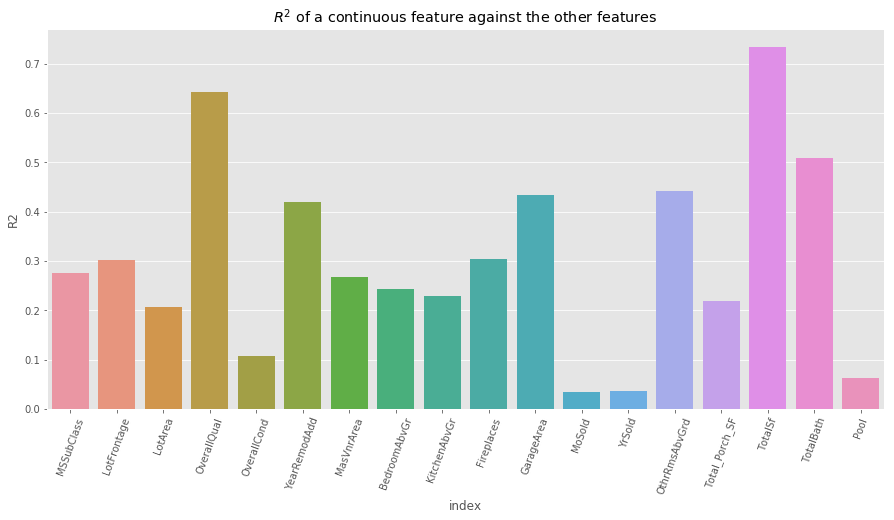

In [129]:
# Visualize multi-collinearity between non-dummified features
plt.figure(figsize=(15,7))
g = sns.barplot(x='index', y='R2', data=pd.DataFrame(scores, index=['R2']).T.reset_index())
plt.xticks(rotation=70)
plt.title('$R^2$ of a continuous feature against the other features')

In [132]:
# Use a simple multiple linear regression as a baseline, even though multi-collinearity 
# and curse of dimensionlity (many features) indicates this may be a bad choice
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression,HuberRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

linR = LinearRegression()
linR.fit(x_train, y_train)
linR_scores = cross_val_score(linR, x_train, y_train, cv=5)

print(np.mean(linR_scores))
print(adj_r_squared(linR,x_train,y_train))

0.8611708551772879


In [135]:
# Try a Huber Regression (with a grid search) - this should handle any outliers well 
hubR = HuberRegressor()
params = {'alpha':10**np.linspace(-2,2,10), 'epsilon': np.linspace(1,2,10)}
grid = GridSearchCV(estimator=hubR, param_grid=params, cv=5)
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'alpha': 4.6415888336127775, 'epsilon': 1.3333333333333333}
0.7325164019274805


In [144]:
# Try a Lasso penalized regression - this has the advantage of helping with feature selection
# Find the optimum lambda
lr = Lasso(normalize=True)

params = {'alpha':10**np.linspace(-6,-3,100)}
grid = GridSearchCV(estimator=lr, param_grid=params, cv=5)

grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,x_train,y_train))
lr_optimal = grid.best_estimator_
lr_optimal.coef_

{'alpha': 0.0001}
0.8696586366694387


In [153]:
# Use bootstrapping to generate confidence intervals for the coefficient estimates from the
# above regression. Any that span zero could be targets for removal
coefs = {}
intercepts = {}

for i in range(1000):
    rIndex = np.random.choice(x_train.index, 400, replace=False) # randomly select 400 samples 1000 times   
    sampled_x = x_train.loc[rIndex]
    sampled_y = y_train.loc[rIndex]

    grid.best_estimator_.fit(sampled_x, sampled_y)
    coefs[i] = grid.best_estimator_.coef_
    intercepts[i] = grid.best_estimator_.intercept_
coefs = pd.DataFrame(coefs)
intercepts= pd.Series(intercepts)
coefs_avg = coefs.apply('mean', axis =1)
coefs_sd = coefs.apply('std',axis = 1)

In [159]:
plt.figure(figsize=(15,7))
coefs_lowlim = coefs_avg - 2*coefs_sd
coefs_uplim = coefs_avg + 2*coefs_sd
coefs_conf = pd.DataFrame({'lower': coefs_lowlim,'upper':coefs_uplim, 'boundary': np.where((coefs_lowlim <0) & (coefs_uplim >0),0,1)})
features_index = coefs_conf[coefs_conf.lower >0].index
x_train.columns[features_index]
# coefs_conf.loc[:,['lower','upper']].plot.line() # Plot if required

Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'GarageArea',
       'Total_Porch_SF', 'TotalSf', 'TotalBath', 'Neighborhood_Crawfor'],
      dtype='object')

<Figure size 1080x504 with 0 Axes>

In [ ]:
# # Plot the magnitudes of the coefficients from the optimum Lasso model that are non-zero
# plt.figure(figsize=(15,7))
# feature_coefs = list(zip(x_train.columns[lr_optimal.coef_!=0], abs(lr_optimal.coef_[lr_optimal.coef_!=0])))
# dtype = [('feature', 'S10'), ('coefs', 'float')]
# feature_coefs = np.array(feature_coefs, dtype=dtype)
# feature_sort = np.sort(feature_coefs, order='coefs')[::-1]
# name, score = zip(*list(feature_sort))
# opt_coefs = pd.DataFrame({'name':name,'score':score})
# plt.bar(x=opt_coefs.name, height=opt_coefs.score)
# plt.xticks(rotation=70)

In [ ]:
# Try a ridge regression
# Find the optimum lambda
rd = Ridge(normalize=True)

params = {'alpha':10**np.linspace(-2,2,100)}

grid = GridSearchCV(estimator=rd,param_grid=params,cv=5)

grid.fit(x_train,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,x_train,y_train))

In [ ]:
# Try an elasticnet regression
# FInd gthe optimum lambda and rho
en = ElasticNet(max_iter=10000,normalize=True)

params = {'alpha':10**np.linspace(-4,0,20),'l1_ratio':np.linspace(0.1,1,20)}

grid = GridSearchCV(estimator=en,param_grid=params,cv=5)

grid.fit(x_train,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,x_train,y_train))

In [ ]:
# Kaggle Submission #1
# Using the results of the above, get a baseline score from submitting the elasticnet 
# model, with no additional feature selection (other than that effected by the L1 penalty)
sub1 = pd.DataFrame(np.exp(grid.predict(test)),index=test.index+1,columns=['SalePrice'])
sub1.to_csv('sub1.csv',sep=',')

In [ ]:
# Visualize the development of the model coefficients in Lasso regression
alphas = 10**np.linspace(-6,-2,100)
lr.set_params(normalize=True)
coefs  = []

for alpha in alphas:
        lr.set_params(alpha=alpha)
        lr.fit(x_train, y_train)  
        coefs.append(lr.coef_)
        
coefs = pd.DataFrame(coefs, index = alphas, columns = x_train.columns)

plt.figure(figsize=(15,7))
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)

plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')

In [ ]:
# Find the ~10 coefficients that take the longest to go to zero
coefs[(coefs.index>0.001)][coefs[(coefs.index>0.001)]!=0].notnull().sum()

######  - The optimal_features set below is made using the results of the above cell. 
######  - Optimal_features_2 contains the coefficients that are non-zero at the optimum lambda found from the lasso grid search. 
###### - Optimal_features_3 contains from the coefficients of the optimum lasso model with confidence intervals that do not span zero 

In [166]:
# Make new feature spaces using only those features that Lasso regression suggests have the
# most explanatory power
optimal_features = x_train.loc[:,['OverallQual','YearRemodAdd','GarageArea','Fireplaces','OthrRmsAbvGrd','TotalBath','MSZoning_RM','MSZoning_RL','MSZoning_RH','MSZoning_FV','CentralAir_Y','FireplaceQu_Gd','FireplaceQu_TA','TotalSf']]
optimal_features2 = x_train.loc[:,x_train.columns[lr_optimal.coef_!=0]]
optimal_features3 = x_train.loc[:,x_train.columns[features_index]]
optimal_features_test = test.loc[:,['OverallQual','YearRemodAdd','GarageArea','Fireplaces','OthrRmsAbvGrd','TotalBath','MSZoning_RM','MSZoning_RL','MSZoning_RH','MSZoning_FV','CentralAir_Y','FireplaceQu_Gd','FireplaceQu_TA','TotalSf']]
optimal_features_test2 = test.loc[:,x_train.columns[lr_optimal.coef_!=0]]
optimal_features_test3 = test.loc[:,x_train.columns[features_index]]

In [ ]:
# Run linear regression with a reduced feature set
linR = LinearRegression()
linR.fit(optimal_features2,y_train)
linR_scores = cross_val_score(linR,optimal_features2,y_train,cv=5)

print(np.mean(linR_scores))
print(adj_r_squared(linR,optimal_features2,y_train))

In [143]:
# Run Huber Regression with a reduced feature set
hubR = HuberRegressor()
params = {'alpha':10**np.linspace(-4,2,10), 'epsilon': np.linspace(1,5,50)}
grid = GridSearchCV(estimator=hubR, param_grid=params, cv=5)
grid.fit(optimal_features2, y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,optimal_features2,y_train))

{'alpha': 4.641588833612772, 'epsilon': 3.4489795918367343}
0.7746780253496797


/Users/georgealster/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [168]:
# Run Lasso regression with a reduced feature set
lr = Lasso(normalize=True)

params = {'alpha':10**np.linspace(-6,-3,100)}
grid = GridSearchCV(estimator=lr,param_grid=params,cv=5)

grid.fit(optimal_features2,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,optimal_features2,y_train))

{'alpha': 3.511191734215127e-05}
0.8751994070504153


In [169]:
# Run Lasso regression with a reduced feature set
lr = Lasso(normalize=True)

params = {'alpha':10**np.linspace(-6,-3,100)}
grid = GridSearchCV(estimator=lr,param_grid=params,cv=5)

grid.fit(optimal_features3,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,optimal_features2,y_train))

{'alpha': 4.037017258596558e-06}
0.8222076044514924


In [113]:
# Run Ridge regression with a reduced feature set
rd = Ridge(normalize=True)

params = {'alpha':10**np.linspace(-4,2,100)}
grid = GridSearchCV(estimator=rd,param_grid=params,cv=5)

grid.fit(optimal_features2,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,optimal_features2,y_train))

{'alpha': 0.1873817422860385}
0.8783381996458315
0.8932263872057469
None


In [35]:
# Kaggle Submission #2
# Compare the previous submission to the result obtained from the Ridge regression with
# the optimal_features reduced feature set
sub2 = pd.DataFrame(np.exp(grid.predict(optimal_features_test)),index=optimal_features_test.index+1,columns=['SalePrice'])
sub2.to_csv('sub2.csv',sep=',')

In [165]:
# Run elasticnet regression with the reduced feature set
en = ElasticNet(max_iter=10000,normalize=True)

params = {'alpha':10**np.linspace(-5,-3,20),'l1_ratio':np.linspace(0.001,1,20)}
grid = GridSearchCV(estimator=en,param_grid=params,cv=5)

grid.fit(optimal_features2,y_train)
print(grid.best_params_)
print(grid.best_score_)
print(adj_r_squared(grid,optimal_features2,y_train))

{'alpha': 0.0001438449888287663, 'l1_ratio': 0.1061578947368421}
0.8784545318325845


In [94]:
#Kaggle Submission #4
# COmpare the previous elasticnet submission to this one, using a different reduced feature set
sub4 = pd.DataFrame(np.exp(grid.predict(optimal_features_test2)),index=optimal_features_test2.index+1,columns=['SalePrice'])
sub4.to_csv('sub4.csv',sep=',')

In [170]:
#Kaggle Submission #5
# Using the bootstrapped values on the lasso regression
sub5 = pd.DataFrame(np.exp(grid.predict(optimal_features_test3)),index=optimal_features_test3.index+1,columns=['SalePrice'])
sub5.to_csv('sub5.csv',sep=',')

#### Non-linear models

In [115]:
# Decision Tree
from sklearn import tree
tree_model = tree.DecisionTreeRegressor()

grid_para_tree = [{
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=60, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=10, scoring='r2', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)
print(adj_r_squared(grid_search_tree,x_train,y_train))

CPU times: user 9.97 s, sys: 1.31 s, total: 11.3 s
Wall time: 41.9 s
0.8572616813223682
None


In [50]:
print(grid_search_tree.best_score_)
print(grid_search_tree.score(x_train,y_train))
print(grid_search_tree.best_params_)

0.8003608878271342
0.875471096462313
{'min_samples_leaf': 7, 'min_samples_split': 43}


In [ ]:
# Kaggle submission 3
# Compare how the tree model does, relative to all the linear models previously
sub4 = pd.DataFrame(np.exp(grid_search_tree.predict(test)),index=test.index+1,columns=['SalePrice'])
sub4.to_csv('sub4.csv',sep=',')

We have implemented some feature selection, but a strength of tree/forest models is their ability to identify those features that contribute most to predicting a given target. Hence make a second input data set, without dropping columns

In [190]:
# Dummify the data set with no columns dropped
pd.set_option("display.max_columns", 500)
all_categorical_rf = all_data_no_drop.select_dtypes(exclude=[np.number]).columns
mergedCat_rf = all_data_no_drop[all_categorical_rf]
mergedCat_rf = pd.get_dummies(mergedCat_rf,drop_first=True)
dummified_full_rf = pd.concat([all_data_no_drop,mergedCat_rf],axis=1)
dummified_full_rf = dummified_full_rf.drop(all_categorical_rf,axis=1)

In [193]:
# Split the data with no columns dropped into train and test
train_rf = dummified_full_rf[dummified_full_rf.SalePrice > 0]
test_rf = dummified_full_rf[dummified_full_rf.SalePrice == 0]
test = test_rf.drop('SalePrice',axis=1)

x_train_rf = train_rf.drop('SalePrice',axis=1)
y_train_rf = np.log(train_rf.SalePrice)

In [194]:
# Run a Random Forest Model on the data with no columns dropped
from sklearn import ensemble

randomForest = ensemble.RandomForestRegressor()

grid_para_forest = [{'n_estimators': [25,50,100],'min_samples_leaf':range(1,10),'min_samples_split':np.linspace(2,30,15,dtype=int),'random_state':[42]}]

grid_search_forest = GridSearchCV(randomForest,grid_para_forest,scoring='r2',cv=5,n_jobs=-1)
%time grid_search_forest.fit(x_train_rf,y_train_rf)

CPU times: user 12.8 s, sys: 2.43 s, total: 15.2 s
Wall time: 10min 51s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'n_estimators': [25, 50, 100], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [195]:
rf_final = grid_search_forest.best_estimator_
print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)

{'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100, 'random_state': 42}
0.8706635769374149


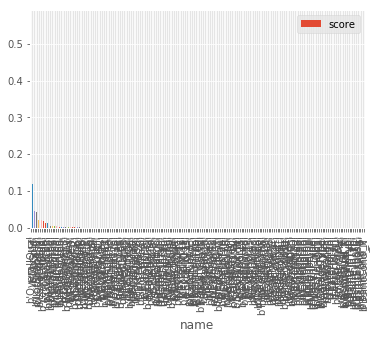

In [199]:
feature_importance = list(zip(x_train.columns, rf_final.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score}).plot.bar(x='name', y='score')
feature_sort

In [54]:
# Submit the predictions of the random forest on the slightly reduced data set
sub3 = pd.DataFrame(np.exp(grid_search_forest.predict(test)),index=test.index+1,columns=['SalePrice'])
sub3.to_csv('sub3.csv',sep=',')

In [97]:
# Submit the predictions of the random forest on the complete data set
sub6 = pd.DataFrame(np.exp(grid_search_forest.predict(test)),index=test.index+1,columns=['SalePrice'])
sub6.to_csv('sub6.csv',sep=',')

### Gradient Boosting

In [209]:
# Gradient boosting regressor using linear
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(verbose=1)

grid_para_boost_lr = [{
#     "learning_rate": np.linspace(start=0.01, stop=0.1, num=10),
    "n_estimators": [100, 500],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": np.linspace(start=2, stop=10, num=5, dtype=int),
    "random_state": [42]}]
grid_search_boost = GridSearchCV(gbm, grid_para_boost_lr, scoring='r2', cv=5, n_jobs=3)
%time grid_search_boost.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.1368            0.84s
         2           0.1182            0.82s
         3           0.1028            0.81s
         4           0.0897            0.80s
         5           0.0792            0.78s
         6           0.0701            0.77s
         7           0.0628            0.76s
         8           0.0565            0.76s
         9           0.0512            0.75s
        10           0.0465            0.75s
        20           0.0234            0.68s
        30           0.0163            0.57s
        40           0.0132            0.48s
        50           0.0114            0.38s
        60           0.0102            0.28s
        70           0.0094            0.21s
        80           0.0088            0.14s
        90           0.0084            0.06s
       100           0.0080            0.00s
CPU times: user 1.55 s, sys: 153 ms, total: 1.7 s
Wall time: 2min 2s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid=[{'n_estimators': [100, 500], 'min_samples_leaf': range(1, 5), 'min_samples_split': array([ 2,  4,  6,  8, 10]), 'random_state': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [210]:
grid_search_boost.best_score_

0.894047477534726

In [211]:
grid_search_boost.best_params_

{'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [ ]:
# Gradient boosting regressor using huber
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(loss = 'huber',verbose = 1)

grid_para_boost_hu = [{
    "alpha": np.linspace(start = 0.75, stop = 0.95, num = 10),
#     "learning_rate": np.linspace(start=0.01, stop=0.1, num=10),
    "n_estimators": [100, 300],
    "min_samples_leaf": range(1, 5),
    "min_samples_split": np.linspace(start=2, stop=10, num=5, dtype=int),
    "random_state": [42]}]
grid_search_boost = GridSearchCV(gbm, grid_para_boost_hu, scoring='r2', cv=5, n_jobs=3)
%time grid_search_boost.fit(x_train, y_train)

In [215]:
# Submit the predictions of the gradient boost regression
sub9 = pd.DataFrame(np.exp(grid_search_boost.predict(test)),index=test.index+1,columns=['SalePrice'])
sub9.to_csv('sub9.csv',sep=',')